# Signal Process Proof of Concept

Just like with Simpl and SndObj, you have to install pyaudio using pip if it's not already there.

ie: 
$ pip install pyaudio

Or even,
$ sudo apt-get install python-pyaudio python3-pyaudio 

Or even better:
sudo git clone http://people.csail.mit.edu/hubert/git/pyaudio.git
sudo apt-get install libportaudio0 libportaudio2 libportaudiocpp0 portaudio19-dev
sudo apt-get install python-dev
cd pyaudio
sudo python setup.py install

http://people.csail.mit.edu/hubert/pyaudio/

# Recording and Producing an Audio File in Real Time (from PyAudio)

In [1]:
import pyaudio
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* Recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* Finished Recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

ImportError: No module named 'pyaudio'

# Effects

Update: I haven't figured out how to apply this function to the actual input in real-time and playback in real-time as of yet.
The system I've outlined takes an already written file and processes it from there. The problem with the above code is that it will only write to an audio file after it's finished recording. I've tried modifying it using a while loop:

    while stream.is_active():
        time.sleep(0.1)
    else
        stream.stop_stream()
        stream.close()
        
...but it didn't work.

# Using Pure Python/Scripy (and help from ThinkDSP)

In [2]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2 

from math import *

import numpy as np
import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interact, interact_manual, fixed
from IPython.html import widgets
from IPython.display import display

from scipy.io.wavfile import read
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Generating the noise, specifically "Uncorrelated Uniform Noise":
thinkdsp.random_seed(17)
signal = thinkdsp.UncorrelatedUniformNoise()
wave = signal.make_wave(duration=0.5, framerate=11025)

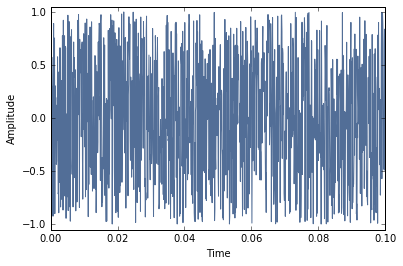

In [4]:
#Waveform  of Noise
segment = wave.segment(duration=0.1)
segment.plot(linewidth=1)
thinkplot.config(xlabel='Time', ylabel='Amplitude', ylim=[-1.05, 1.05], legend=False)

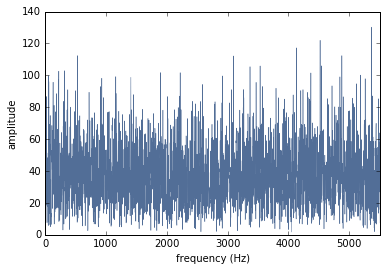

In [5]:
#Spectrum of Noise
spectrum = wave.make_spectrum()
spectrum.plot(linewidth=0.5)
thinkplot.config(xlabel='frequency (Hz)', ylabel='amplitude', xlim=[0, spectrum.fs[-1]])

In [6]:
#What the noise sounds like
wave.make_audio()

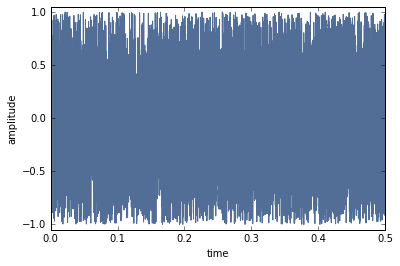

In [7]:
#There's also Brown Noise:
signal2 = thinkdsp.BrownianNoise()
wave2 = signal2.make_wave(duration=0.5, framerate=11025)

wave.plot(linewidth=1)
thinkplot.config(xlabel='time', ylabel='amplitude', ylim=[-1.05, 1.05])
wave2.make_audio()





In [19]:
#And Pink Noise
signal3 = thinkdsp.PinkNoise(beta=1.2)
wave3 = signal3.make_wave(duration=0.5)
wave3.make_audio()
#Where Beta [0,2] changes the parameters of noise.

In [22]:
Input = np.sin(np.pi) #INPUT WAVEFORM

linear_limit = 23197  # About -3 dB
hard_limit = 32767    #When Clipping-effect will occur
clip_limit = linear_limit + int(np.pi/2 * (hard_limit - linear_limit))


def distortion(n):
    amplitude, sign = abs(n), 1 if n >= 0 else -1
    if amplitude <= linear_limit:
        n = Input + signal3
        return n
    if amplitude >= clip_limit: #Included a clipper for extra sound garbage
        return hard_limit * sign
    scale = hard_limit - linear_limit
    compression = scale * sin(float(amplitude - linear_limit) / scale) #Adds additional sound compression for distortion
    return (Input + linear_limit + int(compression)) * sign

# Using PyAudio:

In [ ]:
import numpy as np
from numpy import *

def __init__(self, attack_coeff, release_coeff, delay, dtype=float32):
    self.delay_index = 0
    self.envelope = 0
    self.gain = 1
    self.delay = delay
    self.delay_line = zeros(delay, dtype=dtype)
    self.release_coeff = release_coeff
    self.attack_coeff = attack_coeff

def limit(self, signal, threshold):
    for i in arange(len(signal)):
        self.delay_line[self.delay_index] = signal[i]
        self.delay_index = (self.delay_index + 1) % self.delay

        # calculate an envelope of the signal
        self.envelope *= self.release_coeff
        self.envelope  = max(abs(signal[i]), self.envelope)

        # have self.gain go towards a desired limiter gain
        if self.envelope > threshold:
            target_gain = (1+threshold-self.envelope)
        else:
            target_gain = 1.0
        self.gain = ( self.gain*self.attack_coeff +
                      target_gain*(1-self.attack_coeff) )

        # limit the delayed signal
        signal[i] = self.delay_line[self.delay_index] * self.gain


Combining the two:

In [ ]:
from pyaudio import PyAudio
from pyaudio import paFloat32

pa = PyAudio()
stream = pa.open(format = paFloat32,
                 channels = 1,
                 rate = 44100,
                 output = True,
                 frames_per_buffer = 1024,
                 stream_callback = callback)

while stream.is_active():
    sleep(0.1)

stream.close()
pa.terminate()

limiter = Limiter(attack_coeff, release_coeff, delay, dtype)

def callback(in_data, frame_count, time_info, flag):
    if flag:
        print("Playback Error: %i" % flag)
    played_frames = counter
    counter += frame_count
    limiter.limit(signal[played_frames:counter], threshold)
    return signal[played_frames:counter], paContinue